# Recipe Generation using Recurrent Neural Network (RNN)

## Importing dependencies

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.version())

I0000 00:00:1724949828.970425   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949829.457643   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949829.457695   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Num GPUs Available:  1
Python version: 3.10.12
Tensorflow version: 2.17.0
Keras version: 3.5.0


## Loading the dataset

Let's load the dataset using [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file). Using `get_file()` utility is convenient because it handles caching for you out of the box. It means that you will download the dataset files only once and then even if you launch the same code block once again it will use cache and the download code will be executed faster.

In [2]:
DEBUG = False
DEBUG_EXAMPLES = 10

In [3]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [4]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

Let's download a datasets and preview examples from them.

In [5]:
dataset_raw = load_dataset()  

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [6]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


## Preprocessing the dataset

### Filtering out incomplete examples

In [7]:
# Filters out recipes which don't have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [8]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalide recipes 2226


### Converting recipes objects into strings

To help our RNN learn the structure of the text let's add 3 "landmarks" to it. We will use these unique "title", "ingredients" and "instruction" landmarks to separate a logic sections of each recipe.

In [9]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [10]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [11]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [12]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [13]:
print(dataset_stringified[5000])

📗 Bacon-Wrapped Jalapeno Poppers

🥕

• 1/2 cup cream cheese 
• 1/2 cup shredded sharp Cheddar cheese 
• 12 jalapeno peppers, halved lengthwise, seeds and membranes removed 
• 12 slices bacon 

📝

▪︎ Preheat oven to 400 degrees F (200 degrees C). Line a baking sheet with aluminum foil.
▪︎ Mix cream cheese and Cheddar cheese together in a bowl until evenly blended. Fill each jalapeno half with the cheese mixture. Put halves back together and wrap each stuffed pepper with a slice of bacon. Arrange bacon-wrapped peppers on the prepared baking sheet.
▪︎ Bake in the preheated oven until bacon is crispy, about 15 minutes.



### Filtering out large receipts

Recipes have different lengths. We need to have one hard-coded sequence length limit before feeding recipes sequences to RNN. We need to find out what recipe length will cover most of recipe use-cases and at the same time we want to keep it as small as possible for training performance.

In [14]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

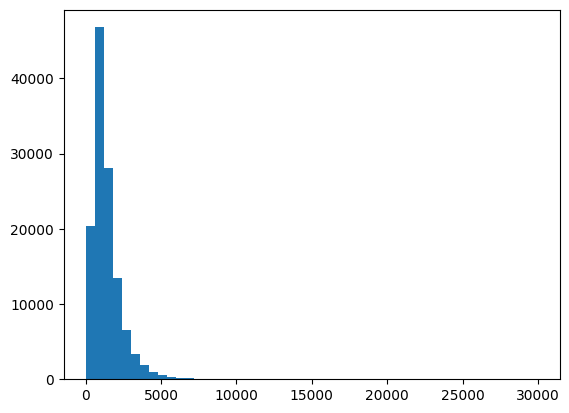

In [15]:
plt.hist(recipes_lengths, bins=50)
plt.show()

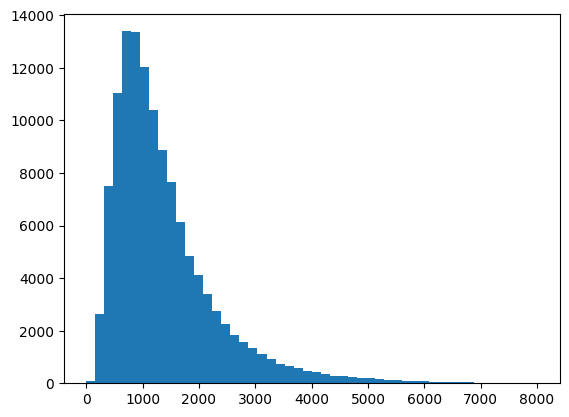

In [16]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [17]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000

if DEBUG:
    MAX_RECIPE_LENGTH = 500

In [18]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [19]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of etiminated recipes:  22726


In [20]:
if DEBUG:
    dataset_filtered = dataset_filtered[:DEBUG_EXAMPLES]
    print('dataset_filtered.shape, ', len(dataset_filtered))

### Summarizing dataset parameters

In [21]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100212


## Creating vocabulary

To create a vocabulary out of recipes texts we will use [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [22]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'

In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [24]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [25]:
tokenizer.fit_on_texts(dataset_filtered)

In [26]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100213,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 100212, " ": 17527888, "S": 270259, "l": 3815150, "o": 5987496, "w": 964459, "C": 222831, "k": 890982, "e": 9296022, "r": 4760887, "h": 2922100, "i": 4911812, "c": 2883507, "n": 5304396, "a": 6067157, "d": 3099679, "D": 63999, "u": 2717050, "m": 1794411, "p": 2679164, "g": 1698670, "s": 4704222, "\\n": 1955281, "\\ud83e\\udd55": 100212, "\\u2022": 922813, "4": 232607, ",": 1130487, "b": 1394803, "t": 5997722, "v": 746785, "2": 493933, "(": 144985, "1": 853931, "0": 145119, ".": 1052548, "7": 31098, "5": 154071, ")": 144977, "f": 1042981, "y": 666553, "\\ud83d\\udcdd": 100212, "\\u25aa": 331058, "\\ufe0e": 331058, "P": 200597, "6": 51398, "H": 43936, "A": 134274, "3": 213519, "R": 101253, "x": 201286, "/": 345257, "I": 81591, "L": 46138, "8": 55352, "9": 17697, "B": 123813, "M": 78684, "F": 104359, "j": 1

In [27]:
# Adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


In [28]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

o
,


In [29]:
tokenizer.word_index['r']

8

In [30]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', '📗', '🥕', '📝', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '?', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'á', 'ó', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', 'à', '_', '\xad', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', 'Á', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '␣', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


In [31]:
# Test proper conversion from text to indices.
# This is needed for debugging a demo app.
tokenizer.texts_to_sequences(['yes'])

[[28, 2, 9]]

## Vectorizing the dataset

Now, once we have a vocabulary (`character --> code` and `code --> character` relations) we may convert the set of recipes from text to numbers (RNN works with numbers as an input and not with the texts).

In [32]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [33]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [34]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100212


In [35]:
print(dataset_vectorized[0][:10], '...')

[51, 1, 33, 10, 5, 23, 1, 35, 5, 5] ...


In [36]:
recipe_sequence_to_string(dataset_vectorized[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



### Add padding to sequences

We need all recipes to have the same length for training. To do that we'll use [tf.keras.preprocessing.sequence.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) utility to add a stop word to the end of each recipe and to make them have the same length.

In [37]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [38]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [39]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [40]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [41]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [42]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  175


### Create TensorFlow dataset 

In [43]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


I0000 00:00:1724949853.373727   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949853.373973   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949853.373991   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949853.552968   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949853.553045   13357 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [44]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

### Split examples on `input` and `target` texts

For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [45]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [46]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [47]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for `[` and tries to predict the index for `T` as the next character. At the next time-step, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [48]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 33 ('S')
Step  3
  input: 33 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 5 ('o')
Step  5
  input: 5 ('o')
  expected output: 23 ('w')
Step  6
  input: 23 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 35 ('C')
Step  8
  input: 35 ('C')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 5 ('o')
Step 10
  input: 5 ('o')
  expected output: 25 ('k')


### Split up the dataset into batches

In [49]:
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [50]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100212
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


In [51]:
# Batch size.
BATCH_SIZE = 64

if DEBUG:
    BATCH_SIZE = DEBUG_EXAMPLES

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

if DEBUG:
    SHUFFLE_BUFFER_SIZE = 1

In [52]:
if DEBUG:
    dataset_train = dataset_targeted \
        .repeat() \
        .batch(BATCH_SIZE, drop_remainder=True)
else:
    dataset_train = dataset_targeted \
      .shuffle(SHUFFLE_BUFFER_SIZE) \
      .batch(BATCH_SIZE, drop_remainder=True) \
      .repeat()

print(dataset_train)

<_RepeatDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>


In [53]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  45 ... 165 165 165]
 [ 51   1  39 ... 165 165 165]
 [ 51   1  33 ... 165 165 165]
 ...
 [ 51   1  64 ... 165 165 165]
 [ 51   1  54 ... 165 165 165]
 [ 51   1  49 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  45  10 ... 165 165 165]
 [  1  39  14 ... 165 165 165]
 [  1  33  10 ... 165 165 165]
 ...
 [  1  64   5 ... 165 165 165]
 [  1  54   4 ... 165 165 165]
 [  1  49   5 ... 165 165 165]], shape=(64, 2000), dtype=int32)


## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this experiment we will use the following layer types:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [54]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

/home/rahul/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1724949855.745238   13758 service.cc:146] XLA service 0x7fae4c002670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724949855.746256   13758 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[5 5 3 5 6 2 2 3]
 [0 3 9 8 3 0 0 2]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01324805 -0.02112343  0.04546851 -0.03076845 -0.0148065 ]
  [ 0.01324805 -0.02112343  0.04546851 -0.03076845 -0.0148065 ]
  [-0.01140987 -0.02626915 -0.03055402  0.0064119  -0.03466596]
  [ 0.01324805 -0.02112343  0.04546851 -0.03076845 -0.0148065 ]
  [-0.01057903 -0.0036929   0.0386238  -0.0426795   0.02847478]
  [ 0.00794536  0.00389731 -0.04669167 -0.03990469  0.00053287]
  [ 0.00794536  0.00389731 -0.04669167 -0.03990469  0.00053287]
  [-0.01140987 -0.02626915 -0.03055402  0.0064119  -0.03466596]]

 [[ 0.02513209 -0.02764129  0.00132181 -0.0296544   0.00620573]
  [-0.01140987 -0.02626915 -0.03055402  0.0064119  -0.03466596]
  [-0.03653716 -0.01862849  0.02787452  0.02907345  0.01886601]
  [ 0.03552521  0.04822198 -0.02725009 -0.04678684 -0.00675612]
  [-0.01140987 -0.02626915 -0.03055402  0.0064119  -

I0000 00:00:1724949856.359172   13758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Model 1

In [55]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [106]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    input_shape = (batch_size, None)
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=False,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    model.build(input_shape)
    return model

In [107]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (64, None, 256)        │        45,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (64, None, 1024)       │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (64, None, 176)        │       180,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,472,432 (20.88 MB)

 Trainable params: 5,472,432 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

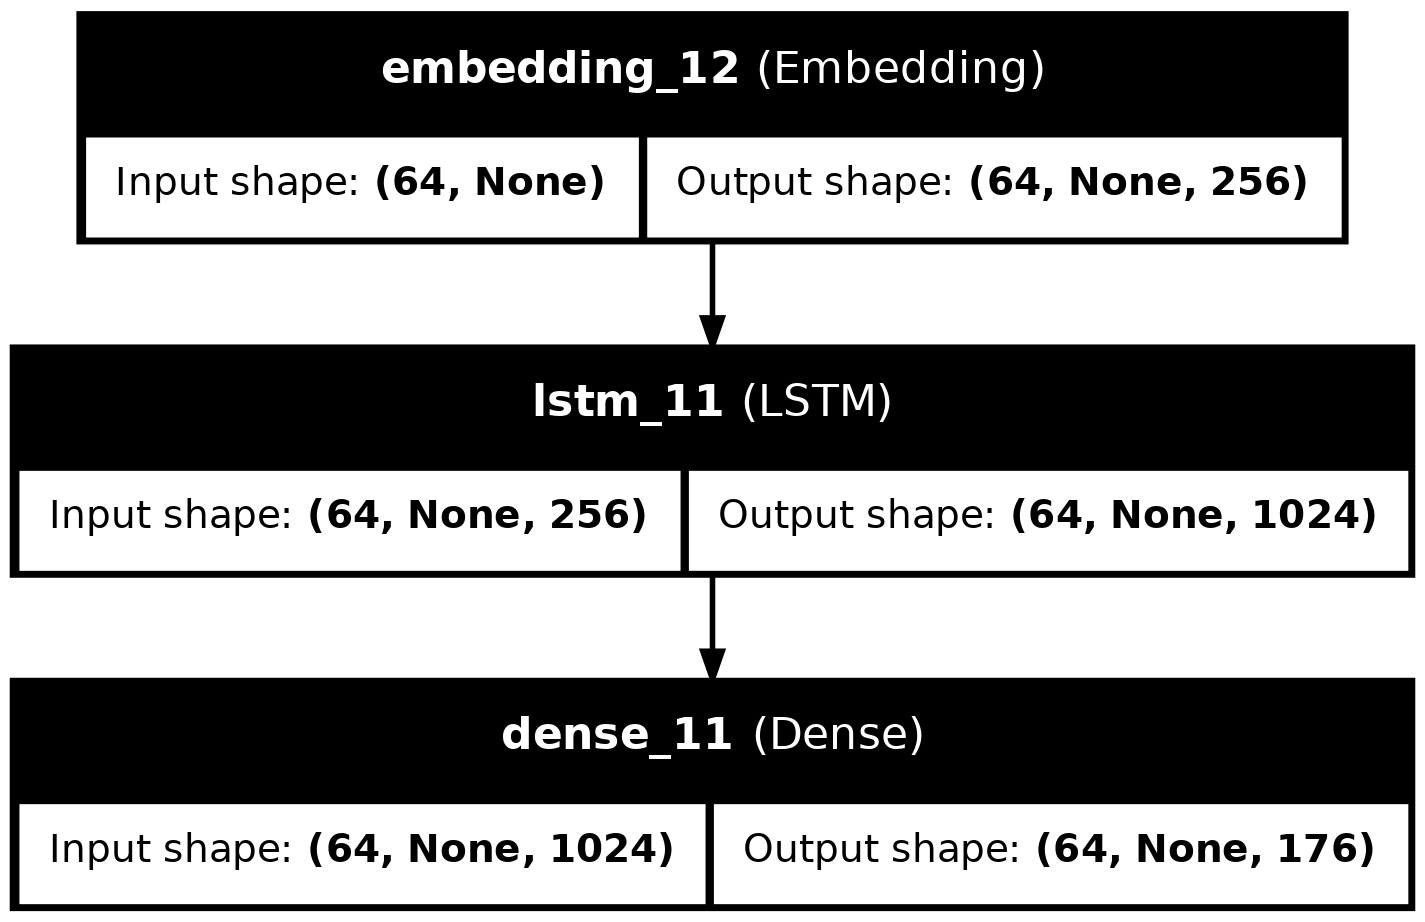

In [108]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

For each character the model looks up the embedding, runs the LSTM one time-step with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Trying the model

In [109]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [110]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-4.4231080e-03  3.8870012e-03 -4.0799831e-03  3.2487884e-04
  1.8952788e-03  5.1554674e-03  5.1247916e-04 -5.2751494e-03
  1.3371834e-03  3.1028269e-03  2.1978300e-03 -7.8032725e-03
 -7.3847151e-04  2.9690855e-04 -3.3723039e-04  3.0096048e-03
  8.4405357e-04  1.5786721e-03 -2.4710789e-05 -7.7258088e-03
 -2.5554523e-03  9.3571545e-04  8.1953537e-03  3.0821688e-03
 -8.1632882e-03  4.1597863e-03  1.2496492e-03  2.5731116e-03
 -3.2755355e-03  7.8009721e-03  2.2698161e-03 -3.0137582e-03
 -3.5910469e-03  6.7345216e-04  1.8694265e-03  1.3384287e-03
  2.9814492e-03 -4.1039060e-03 -1.1075614e-03  1.9511746e-05
 -2.9164723e-03  1.6836997e-03 -2.7488100e-03  1.6959725e-03
 -4.6805848e-04  2.4302593e-03 -3.7530684e-04 -4.0237173e-03
  1.6173837e-03  4.0618149e-03 -3.9538448e-03  7.5669545e-03
  1.8350210e-03  4.3830872e-03 -5.0348598e-03 -1.7911930e-03
  3.3852705e-03 -2.1467721e-03  2.0964118e-04  1.3105242e-03
 -2.8264141e-03 -

In [111]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 1 2 1]], shape=(1, 5), dtype=int64)


In [112]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [113]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [114]:
sampled_indices[:100]

array([175,  63,  15,  42, 162,  85, 121,  14, 152, 155,  95,   6, 155,
        68,  14,  68, 163,  87,  71, 134, 103,  25,  76, 126, 146,  26,
        55,  33,   4,  48,  74,  65, 136,  68,  75, 126, 112, 136,  37,
       172,  34,  81, 117, 108, 163, 104, 116,  70,  86, 130, 142, 149,
        50,  66,  12, 133, 109, 112,  47, 113, 152, 172, 163, 160, 147,
       125, 173, 127, 107,  18, 120,  28, 125, 151,  80,  85,  41,   2,
       145, 140,   0, 141,  57,  70, 174, 167,  67,  32, 142, 161,   6,
       118,  99,  28, 125,  50, 120, 132,  49,   4])

In [115]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   H o n e y - G a r l i c   S l o w   C o o k e r   C h i c k e n   T h i g h s \n \n 🥕 \n \n •   4  '

Next char prediction:
 "\x95 L p ( ´ – \xad u ` \x97 — n \x97 ' u ' ‒ % 9 ì © k ® ⁄ “ 1 M S t F V : \x96 ' J ⁄ ï \x96 3 ⅞ 4 Q ü < ‒ ¼ [ K & ́"


### Trying the model with variable input

In [116]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 176) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

## Training the model

### Attach an optimizer, and a loss function

In [117]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.168969


In [118]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configuring checkpoints

In [119]:
# !rm -rf './tmp/checkpoints'

In [120]:
# Directory where the checkpoints will be saved.
checkpoint_dir = './tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = tf.train.Checkpoint(model=model_1, optimizer=adam_optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)

In [121]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [122]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [123]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('-')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [124]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [125]:
# Unzip uploaded checkpoint to checkpoints folder if needed
# unzip_checkpoint('ckpt_10.zip')

In [126]:
# Loading the latest training data from checkpoints if needed.
# model_1 = model_weights_from_latest_checkpoint(model_1)

In [127]:
# Loading weights from H5 file if needed.
# model_1.load_weights('recipe_generation_rnn_batch_64.h5')

### Configuring callbacks

In [128]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [129]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt-{epoch}.weights.h5')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [ ]:
history_1 = {}
print(history_1)

In [134]:
INITIAL_EPOCH  = 0 #initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 1
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 500

print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)



INITIAL_EPOCH:    0
EPOCHS_DELTA:     1
EPOCHS:           1
STEPS_PER_EPOCH:  500


In [136]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.keras'
model_1.save(model_name)
checkpoint_manager.save(EPOCHS)
download_latest_checkpoint(zip_only=True)

500/500 ━━━━━━━━━━━━━━━━━━━━ 311s 622ms/step - loss: 0.8807
Restoring model weights from the end of the best epoch: 1.
latest_checkpoint_path:  ./tmp/checkpoints/ckpt-1
latest_checkpoint_name:  ckpt-1
---

Checkpoint files:
  - ckpt-1.data-00000-of-00001
  - ckpt-1.index
  - ckpt-1.weights.h5
---

Zipped to:  ckpt-1.zip


In [137]:
loss = []
for initial_epoch in history_1:
    loss += history_1[initial_epoch].history['loss']
print(loss)

[0.6375023126602173]


### Downloading latest checkpoint

In [138]:
# Download zipped latest checkpoint to local drive.
# download_latest_checkpoint(zip_only=True)

In [139]:
# model_name = 'recipe_generation_rnn_raw_' + INITIAL_EPOCH + '.h5'
# model_1.save(model_name, save_format='h5')

### Visualizing training progress

In [140]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

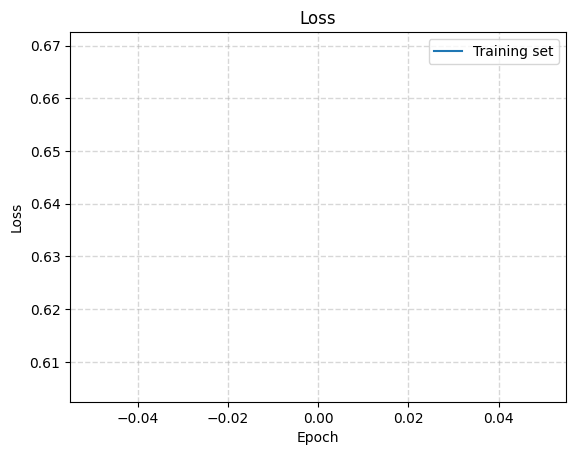

In [141]:
render_training_history(history_1)

## Generating text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [142]:
tf.train.latest_checkpoint(checkpoint_dir)

'./tmp/checkpoints/ckpt-1'

In [143]:
# simplified_batch_size = 1
# model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
# model_1_simplified.load_weights('recipe_generation_rnn.h5')

In [173]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights("recipe_generation_rnn.h5")

#model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [174]:
model_1_simplified.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (1, None, 256)         │        45,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (1, None, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, None, 176)         │       180,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,472,432 (20.88 MB)

 Trainable params: 5,472,432 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model_1_simplified.input_shape

(1, None)

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [176]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE+start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    #model.reset_states()
    for char_index in range(num_generate):
        predictions = model.predict(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [177]:
from IPython.utils import io
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            print(f'Attempt: "{letter}" + {temperature}')
            with io.capture_output() as captured:
                generated_text = generate_text(
                    model,
                    start_string=letter,
                    num_generate = recipe_length,
                    temperature=temperature
                )
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [178]:
generate_combinations(model_1_simplified)

Attempt: "Mushroom" + 1.0
-----------------------------------
📗 MushroommJ'EJ▪︎▪︎.2445034645558cKS™—–[FOHON)‧PT,M#)
▪︎6476646464463PASALFFFFFFRA▪︎▪︎␣␣␣␣␣␣␣␣▪︎PTRIE®,0185054666—%®)•CHOS™B)
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪︎6E®)
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪N)+␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪︎667676565“5‒ydIALPLPCE®)
▪︎CRIE®),VYé▪︎3648):863PLIDUE®)
␣␣␣␣␣␣␣▪︎66764483650cO🥕)•Z/7666464643å␣␣␣␣␣␣␣▪︎6467466464½2550364623764%ACYACEJ▪BkgUEJ7644460CDIENE®)
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪︎460
▪︎646663¿SWACOEJ63466645046NUENZ:⁄509,⁄GIEJ▪︎64646+␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪­25LON)• •
␣▪︎  .66646—%O™-6463⅓ëPLACDKRAS®)•]KJONZFFFFHRWUVàj);CO•Z,45CA;>1‟=J69995463DUOEJ766-%ON,V[3PLOE®)
␣␣␣␣▪’Jo🥕
␣␣␣␣▪Úiî⁄2366509;>25646%ONLbkgE®)nø­VUDW®).␣␣␣␣␣␣␣▪UEN:J:J747644566456446DIENUEN)•]̀l📝
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣▪FFFRAVî▪︎ GOIN&N)(UDDFFS™ 🥕
␣␣␣␣␣␣␣␣␣␣␣▪-76463PLOS™™:⅓5624543""">SS™®)í“264646)
␣␣␣␣␣␣␣␣▪︎646464644545564666466666’ä⁄J2764464#LON)•;366645460836656643PACONUE®)
␣␣␣▪︎#795+␣␣␣␣␣␣▪︎CTVIN)
␣␣␣␣␣▪︎␣␣␣␣␣␣␣␣␣␣▪‒A;343NDEJ644664664LFFFFH.␣▪︎6976%ONZA▪︎

KeyboardInterrupt: 

## Save the model

In [ ]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/recipe_generation_rnn/recipe_generation_rnn.h5 \
  ./demos/public/models/recipe_generation_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.